In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from numpy import array
import datetime
import io
import webbrowser
from IPython.display import clear_output, Image, display, HTML
import math
import shutil
import glob
import os
from tensorflow.python.ops import array_ops

logs_path_test= 'logs/'

In [2]:
def delete_logs_archive():
    try:
        shutil.rmtree(logs_path_test)
    except OSError:
        pass

In [3]:
delete_logs_archive()

In [4]:
#expected soemthing like this (e.g.): load_plot_to_tensorboard([range(len(train_data)),train_data,'k',"simple presentation of orginal data"], [same structue], ..., z)
#expected something like this (e.g.): load_plot_to_tensorboard_x_plots_y_scatter()
def load_plot_to_tensorboard_x_plots_y_scatter(plots=[],scatter=[],name="Not Specified"):
    plt.ioff()
    plt.figure(figsize=(40, 15))
    plt.title('stock market prediction - Prediction on Prediction')
    for i in plots:
        plt.plot(i[0],i[1],i[2])
    for j in scatter:
        plt.scatter(x=j[0],y=j[1],c=j[2]) 
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image=tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return tf.summary.image(name,image,max_outputs=1)

In [5]:
# data_list expected: [data_set,scaled_dataset,training_data,test_data]
def create_and_add_summaries(data_list,writer=None,session=None):
    color_original_data_plot='b'
    color_train_data_plot='g'
    color_original_data_scatter='blue'
    color_train_data_scatter='green'
    color_test_data_plot='m'
    color_test_data_scatter="magenta"
    
    summary_original_unscaled = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(len(data_list[0])),data_list[0],color_original_data_plot]],name="UNSCALED_ORIGINAL_DATA_PLOT"))
    summary_original = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(len(data_list[1])),data_list[1],color_original_data_plot]],name="ORIGINAL_DATA_PLOT"))
    summary_train = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_plot]],name="TRAIN_DATA_PLOT"))
    summary_original_with_train = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(len(data_list[1])),data_list[1],color_original_data_plot],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_plot]],name="ORIGINAL_DATA_AND_TRAIN_DATA_PLOT"))
    summary_test = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_plot]],name="TEST_DATA_PLOT"))
    summary_test_with_train = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_plot],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_plot]],name="TEST_AND_TRAIN_DATA_PLOT"))
    summary_all = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(len(data_list[1])),data_list[1],color_original_data_plot],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_plot],[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_plot]],name="SUMMARIZE_ALL_PLOT"))
    
    summary_original_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(len(data_list[1])),data_list[1],color_original_data_scatter]],name="ORIGINAL_DATA_SCATTER"))
    summary_train_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_scatter]],name="TRAIN_DATA_SCATTER"))
    summary_original_with_train_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(len(data_list[1])),data_list[1],color_original_data_scatter],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_scatter]],name="ORIGINAL_DATA_AND_TRAIN_DATA_SCATTER"))
    summary_test_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_scatter]],name="TEST_DATA_SCATTER"))
    summary_test_with_train_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_scatter],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_scatter]],name="TEST_AND_TRAIN_DATA_SCATTER"))
    summary_all_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(len(data_list[1])),data_list[1],color_original_data_scatter],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_scatter],[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_scatter]],name="SUMMARIZE_ALL_SCATTER"))
    
    summary_list = [summary_original_unscaled,summary_original,summary_train,summary_original_with_train,summary_test,summary_test_with_train,summary_all,summary_original_scatter,summary_train_scatter,summary_original_with_train_scatter,summary_test_scatter,summary_test_with_train_scatter,summary_all_scatter]
    for i in summary_list:
        writer.add_summary(i)
    

In [6]:
# expect something like this (e.g.): plot_dataframe_with_args([source_data_x,source_data_y,color],[result_data_x, result_data_y, color]) 
def plot_dataframe_with_args(*args):#(x_source, y_source, color_source, x_results, y_results, color_results, add_offset = False):
    print("\nNumber of existing points: ", len(args[0][1]))
    for i in args:
        if i != args[0]:
            print("Number of predicted points: ", len(i[1]))
    print("\n")
    plt.figure(figsize=(60, 25))
    plt.title('stock market prediction - Prediction on Prediction')
    plt.xlabel('days')
    plt.ylabel('dayli-closing-price in Dollar')
    for i in args:
        plt.plot(i[0],i[1],i[2]) 
    plt.show()

In [7]:
def read_dataframe_and_output_dataset(name):
#     Adidas
#     tesla_stocks = pd.read_csv('AdidasAG10Years.csv')
#     tesla_stocks.head()
#     data_to_use = tesla_stocks['close'].values
#     data_to_use = np.flipud(data_to_use) # flips values to get the newest values to the end

    data_set = np.arange(0,8*math.pi,0.2)
    data_to_use = [math.sin(x) for x in data_set] # + 0.1*math.sin(10*x) 
    return data_to_use
    

In [8]:
def scale_dataset(min,max,dataset): #dataset shape: [x]
    scaler = MinMaxScaler(feature_range=(-2,2))
    scaler = scaler.fit(dataset)
    scaled_dataset = scaler.transform(dataset)
    return scaler, scaled_dataset

In [9]:
def scale_dataset_back(scaler, dataset): #dataset shape: [x]
    return scaler.inverse_transform(dataset)

In [10]:
#if reshaped = False ->(None) to (None,1)
#if reshaped = True -> (None,1) to (None)
def reshape_dataset(dataset, reshaped):
    if reshaped is False:
        dataset = np.reshape(dataset, (-1,1))
    else:
        dataset = np.reshape(dataset, (-1))
    return dataset
    

In [11]:
# is needed because output from Training is [batch_size,1] and all appended : [number_of_batches,batch_size,1]
def unpack_predictions(prediction):
    sup =[]
    for i in range(len(prediction)):
        for j in range(len(prediction[i])):
            sup.append(prediction[i][j])
    return sup

In [12]:
def unpack_predictions_test(tests):
    test_results = []
    for i in range(len(tests)):
        for j in range(len(tests[i][0])):
            test_results.append(tests[i][0][j])
    return test_results

In [13]:
#requires dataset of shape (-1,1)
def window_data(reshaped_data, window_size):
    x = []
    y = []    
    i = 0
    while (i + window_size) <= len(reshaped_data) - 1: #heißt eigentlich nach windowsSize Tagen = eine Prediction
        x.append(reshaped_data[i:i+window_size])
        y.append(reshaped_data[i+window_size])        
        i += 1
    assert len(x) ==  len(y)
    return x, y

In [14]:
#requires windowed_dataset
def create_trains(windowed_data_x,windowed_data_y):
    x_train  = np.array(windowed_data_x[:train_range])
    y_train = np.array(windowed_data_y[:train_range])

    x_test = np.array(windowed_data_x[train_range:])
    y_test = np.array(windowed_data_y[train_range:])
    return x_train, y_train, x_test, y_test

In [15]:
def create_lstm_cell_with_MultiRNN_Dropout(neurons_at_gate, batch_size,number_of_lstm_layers,dropout_rate):
    layer_list = []
    for counter in range(number_of_lstm_layers):
        layer = tf.nn.rnn_cell.BasicLSTMCell(neurons_at_gate)
        if dropout_rate != 0:
            pass
            #layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        layer_list.append(layer)     
    cell = tf.contrib.rnn.MultiRNNCell(layer_list) 
    init_state = cell.zero_state(1, tf.float32) #zero_state -> alle values to 0
    return cell, init_state
    

In [16]:
# use for given accuracy function
#requires x shape of: 
def my_tf_round(x, decimal_place = 0):
    multiplier = tf.constant(10**decimal_place, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [17]:
# requires logits and labels shape of: (batch_size,feature_size), normal_case: (8,1)
def accuracy(logits,labels,decimal_place):    
    targets_rounded = my_tf_round(labels,decimal_place)
    logits_rounded = my_tf_round(logits,decimal_place)
    correct_prediction=tf.equal(logits_rounded,targets_rounded)
    accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    return accuracy

In [18]:
def input_layer():
    x_batch = tf.placeholder(tf.float32, [1, window_size, 1], name='input_data')
    y_batch = tf.placeholder(tf.float32, [batch_size, 1], name='targets')
    loss_holder_for_logits = tf.placeholder(tf.float32, [batch_size, 1], name='loss_input_after_batch')
    bisherige_logits_placeholder = tf.placeholder(tf.float32, [batch_size-1,1], name='list_of_trainable_variables')
    return x_batch,y_batch,loss_holder_for_logits,bisherige_logits_placeholder

In [19]:
def compute_rnn(x_batch,cell1,initial_state):
    output_dynamic_cell,states = tf.nn.dynamic_rnn(cell1, x_batch, initial_state=initial_state)
    return output_dynamic_cell, states

In [20]:
#lstm_output = (batch_size,window_size,neurons_at_gate)
#number of classes = often 1
#predictions_for_batch = (batch_size,number_of_features)
def output_layer(lstm_output, neurons_at_gate, number_of_features):  
    x = lstm_output[:, -1, :] 
    weights = tf.Variable(tf.truncated_normal([neurons_at_gate, number_of_features], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([number_of_features]), name='output_layer_bias')
    predictions_for_batch = tf.matmul(x, weights) + bias 
    return predictions_for_batch

In [21]:
def loss(logit, targets,bisherige_logits_placeholder): 
    logits = tf.concat([bisherige_logits_placeholder,logit],0,name="add_logit_to_logitlist")

    
    
    
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))]) #mse      
    loss = tf.reduce_sum(losses)/(2*batch_size)
    return logits, loss   

In [22]:
def optimize(loss,learning_rate,clip_on,):
    gradients = tf.gradients(loss, tf.trainable_variables(),name="gradientsCalculated") 
    clipper_, _ = tf.clip_by_global_norm(gradients, clip_on,name="ClipperIsSetTo4")
    optimizer = tf.train.AdamOptimizer(learning_rate,name="AdamOptimizer")
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()),name="applyGradientsForOptimisation")
    return train_optimizer

In [23]:
def run_batch(session,x_batch,y_batch):
        logits_result,loss_result,accuracy_result,optimizer_result = session.run([logits,loss,accuracy,optimizer],feed_dict={x_batch_placeholder:x_batch,y_batch_placeholder:y_batch})
        return logits_result,loss_result,accuracy_result,optimizer_result
                                                                                                 

In [24]:
def run_batch_test(session,x_batch): #x_batch sollte eigentlich nur 1 window, mit dem man dann nicht nur 1 sondern x batches predicten kann
    logits_test_result = session.run([logit],feed_dict={x_batch_placeholder:x_batch})
    return logits_test_result

In [25]:
# def run_all_epochs(session,x_train,y_train,dataset,scaled_dataset,summary_writer):
    
    
#     epoch_loss = []
#     accuracy = 0.0
#     total_batch=0
#     traind_scores = []
    
#     for i in range(epochs):
#         epoch_loss = []
#         accuracy = 0.0
#         total_batch=0
#         traind_scores = [] 
#         ii = 0
#         while(ii + batch_size) <= len(x_train): #ein Durchlauf = 1 batch = 1 BPTT = 1 Anpassung der Gewichte = 1x "Lernen"
#             x_batch = x_train[ii:ii+batch_size]
#             y_batch = y_train[ii:ii+batch_size]
#             logits,loss,accuracy,optimizer = run_batch(session,x_batch,y_batch)
#             total_batch+=1
#             ii += batch_size
            
#             epoch_loss.append(loss)
#             traind_scores.append(logits)
#         if (i % 1) == 0:
#             print('Epoch {}/{}'.format((i+1), epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    
#     prediction_list = unpack_predictions(traind_scores) #reason: from [number_of_batches,batch_size,1] to [-1]
#     return prediction_list
#     #dataset = scale_dataset_back(scaler, dataset)

In [26]:
def run_all_epochs(session,x_train,y_train,dataset,scaled_dataset,summary_writer):
    
    
    epoch_loss = []
    accuracy = 0.0
    total_batch=0
    traind_scores = []
    epoch_number = 1
    
    for i in range(epochs):
        
        epoch_loss = []
        accuracy = 0.0
        traind_scores = [] 
        ii = 0
        preds_list = np.array([[]])

        
        
        while(ii + batch_size) <= len(x_train): #ein Durchlauf = 1 batch = 1 BPTT = 1 Anpassung der Gewichte = 1x "Lernen"
            x_batch = x_train[ii]
            y_batch = y_train[ii:ii+batch_size]
            preds_list = np.array([[]])
            
            for i in range(batch_size-1):
                x_batch = np.reshape(x_batch,[1,window_size,1])
                logit_pred_result = session.run(logit,feed_dict={x_batch_placeholder:x_batch})
                # wir müssen jetzt diese Prediction an x_batch heran machen, dazu braucehn wir die shape von logits_preds_result müsste eig 1x1 sein
#                 print(preds_list.shape(), logit_pred_result.shape())
        
                preds_list = np.append(preds_list,logit_pred_result)
                preds_list = np.reshape(preds_list,[-1,1])
        
                
            
            
                logit_pred_result = logit_pred_result.reshape([-1])
                x_batch = np.reshape(x_batch,[-1])
                x_batch = x_batch[1:]
                # Using predict value to replace real value
                x_batch = np.append(x_batch, logit_pred_result)
                x_batch = x_batch.reshape(-1, window_size, 1)
            # end for-loop    
                
            x_batch = np.reshape(x_batch,[1,window_size,1])
            
            full_pred_list_result, loss_result, optimizer_result = session.run([full_pred_list,loss,optimizer],feed_dict={y_batch_placeholder:y_batch,x_batch_placeholder:x_batch,bisherige_logits_placeholder:preds_list})
            
            # wir müssen jetzt diese Prediction an x_batch heran machen, dazu braucehn wir die shape von logits_preds_result müsste eig 1x1 sein
            #preds_list = np.append(preds_list,logit_pred_result, axis=1)
            #logit_preds_result = logit_preds_result.reshape([-1])
            #x_batch = np.reshape(x_batch,[-1])
            #x_batch = x_batch[1:]
            # Using predict value to replace real value
            #x_batch = np.append(x_batch, logit_preds_result)
            #x_batch = x_batch.reshape(-1, window_size, 1)
        
            
            total_batch+=1
            ii += batch_size
            

            traind_scores.append(full_pred_list_result)
          
            
            epoch_loss.append(loss_result)
        if (i % 1) == 0:
            print('Epoch {}/{}'.format(epoch_number, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
            epoch_number+=1
    
    prediction_list = unpack_predictions(traind_scores) #reason: from [number_of_batches,batch_size,1] to [-1]
    return prediction_list,epoch_loss

In [27]:
def test_network(session,x_test,summary_writer):  
    tests = []
    i = 0
    x_batch1 = x_test[0]
    print(np.shape(x_batch1))
    x_batch1 = np.reshape(x_batch1,[1,window_size,1])
    print(np.shape(x_batch1))
    
    
    
    
    while i <= number_of_disired_predictions:
        logit_output = run_batch_test(session,x_batch1)  #output wird sein [1,1]
        tests.append(logit_output)
        logit_output_reshaped = np.reshape(logit_output,(-1))
        x_batch_reshaped = np.reshape(x_batch1,(-1))
        x_batch_reshaped = x_batch_reshaped[1:]
        x_batch_new_data_reshaped = np.append(x_batch_reshaped,logit_output_reshaped)
        x_batch1 = np.reshape(x_batch_new_data_reshaped,(1,window_size,1))
        i += 1  
    result = unpack_predictions_test(tests)
    return result

In [28]:
def run_all(session):
    summary_writer = tf.summary.FileWriter(logs_path_test,session.graph)
    dataset=read_dataframe_and_output_dataset("AdidasAG10Years.csv")
    reshaped_data = reshape_dataset(dataset, False)
    scaler, scaled_dataset = scale_dataset(-1,1,reshaped_data)
    windowed_data_x, windowed_data_y = window_data(scaled_dataset, window_size)
    x_train, y_train, x_test, y_test = create_trains(windowed_data_x,windowed_data_y)
    
    prediction_list,epoch_loss = run_all_epochs(session,x_train,y_train,dataset,scaled_dataset,summary_writer)
    result = test_network(session,x_test,summary_writer)
    
    print("shape of test_data: ", np.shape(np.array(scaled_dataset)))
    plot_dataframe_with_args([[i for i in range(len(epoch_loss))],epoch_loss,'b'])
    plot_dataframe_with_args([[i for i in range(len(scaled_dataset))],scaled_dataset,'b'],[[i for i in range(window_size,window_size+len(prediction_list))],prediction_list,'g'],[[i for i in range(window_size + train_range,window_size + train_range+len(result))],result,'m'])
    
    #create_and_add_summaries([dataset,scaled_dataset,prediction_list,result],writer=summary_writer,session=session) # if dataset changes, method have to be changed (updated)

    summary_writer.close()

In [29]:
# Bedingung: window_size >= batch_size
window_size = 24 #arbitrarily selectable value
batch_size = 8
epochs = 5 #eig 3
train_range = 80 #has to be dividable by batch_size
dropout_rate=0
number_of_lstm_layers= 1
learning_rate=0.0001
neurons_at_gate=512
number_of_classes = 1 #ist glaube gleich mit number of features
decimal_place = 1
clip_on = 4
number_of_disired_predictions = 50
#number_of_features



x_batch_placeholder,y_batch_placeholder,loss_placeholder_for_logits, bisherige_logits_placeholder = input_layer()
cell, initial_state = create_lstm_cell_with_MultiRNN_Dropout(neurons_at_gate, batch_size, number_of_lstm_layers,dropout_rate)    
outputs, states =  compute_rnn(x_batch_placeholder,cell,initial_state=initial_state)  
logit = output_layer(outputs, neurons_at_gate, number_of_classes)
full_pred_list,loss = loss(logit,y_batch_placeholder, bisherige_logits_placeholder)
#accuracy = accuracy(logits,y_batch_placeholder,decimal_place)
optimizer= optimize(loss,learning_rate,clip_on)

start
Epoch 1/5  Current loss: 0.9605188369750977
Epoch 2/5  Current loss: 0.7439882755279541
Epoch 3/5  Current loss: 0.30112236738204956
Epoch 4/5  Current loss: 0.04445602372288704
Epoch 5/5  Current loss: 0.0119556225836277
(24, 1)
(1, 24, 1)
shape of test_data:  (126, 1)

Number of existing points:  10




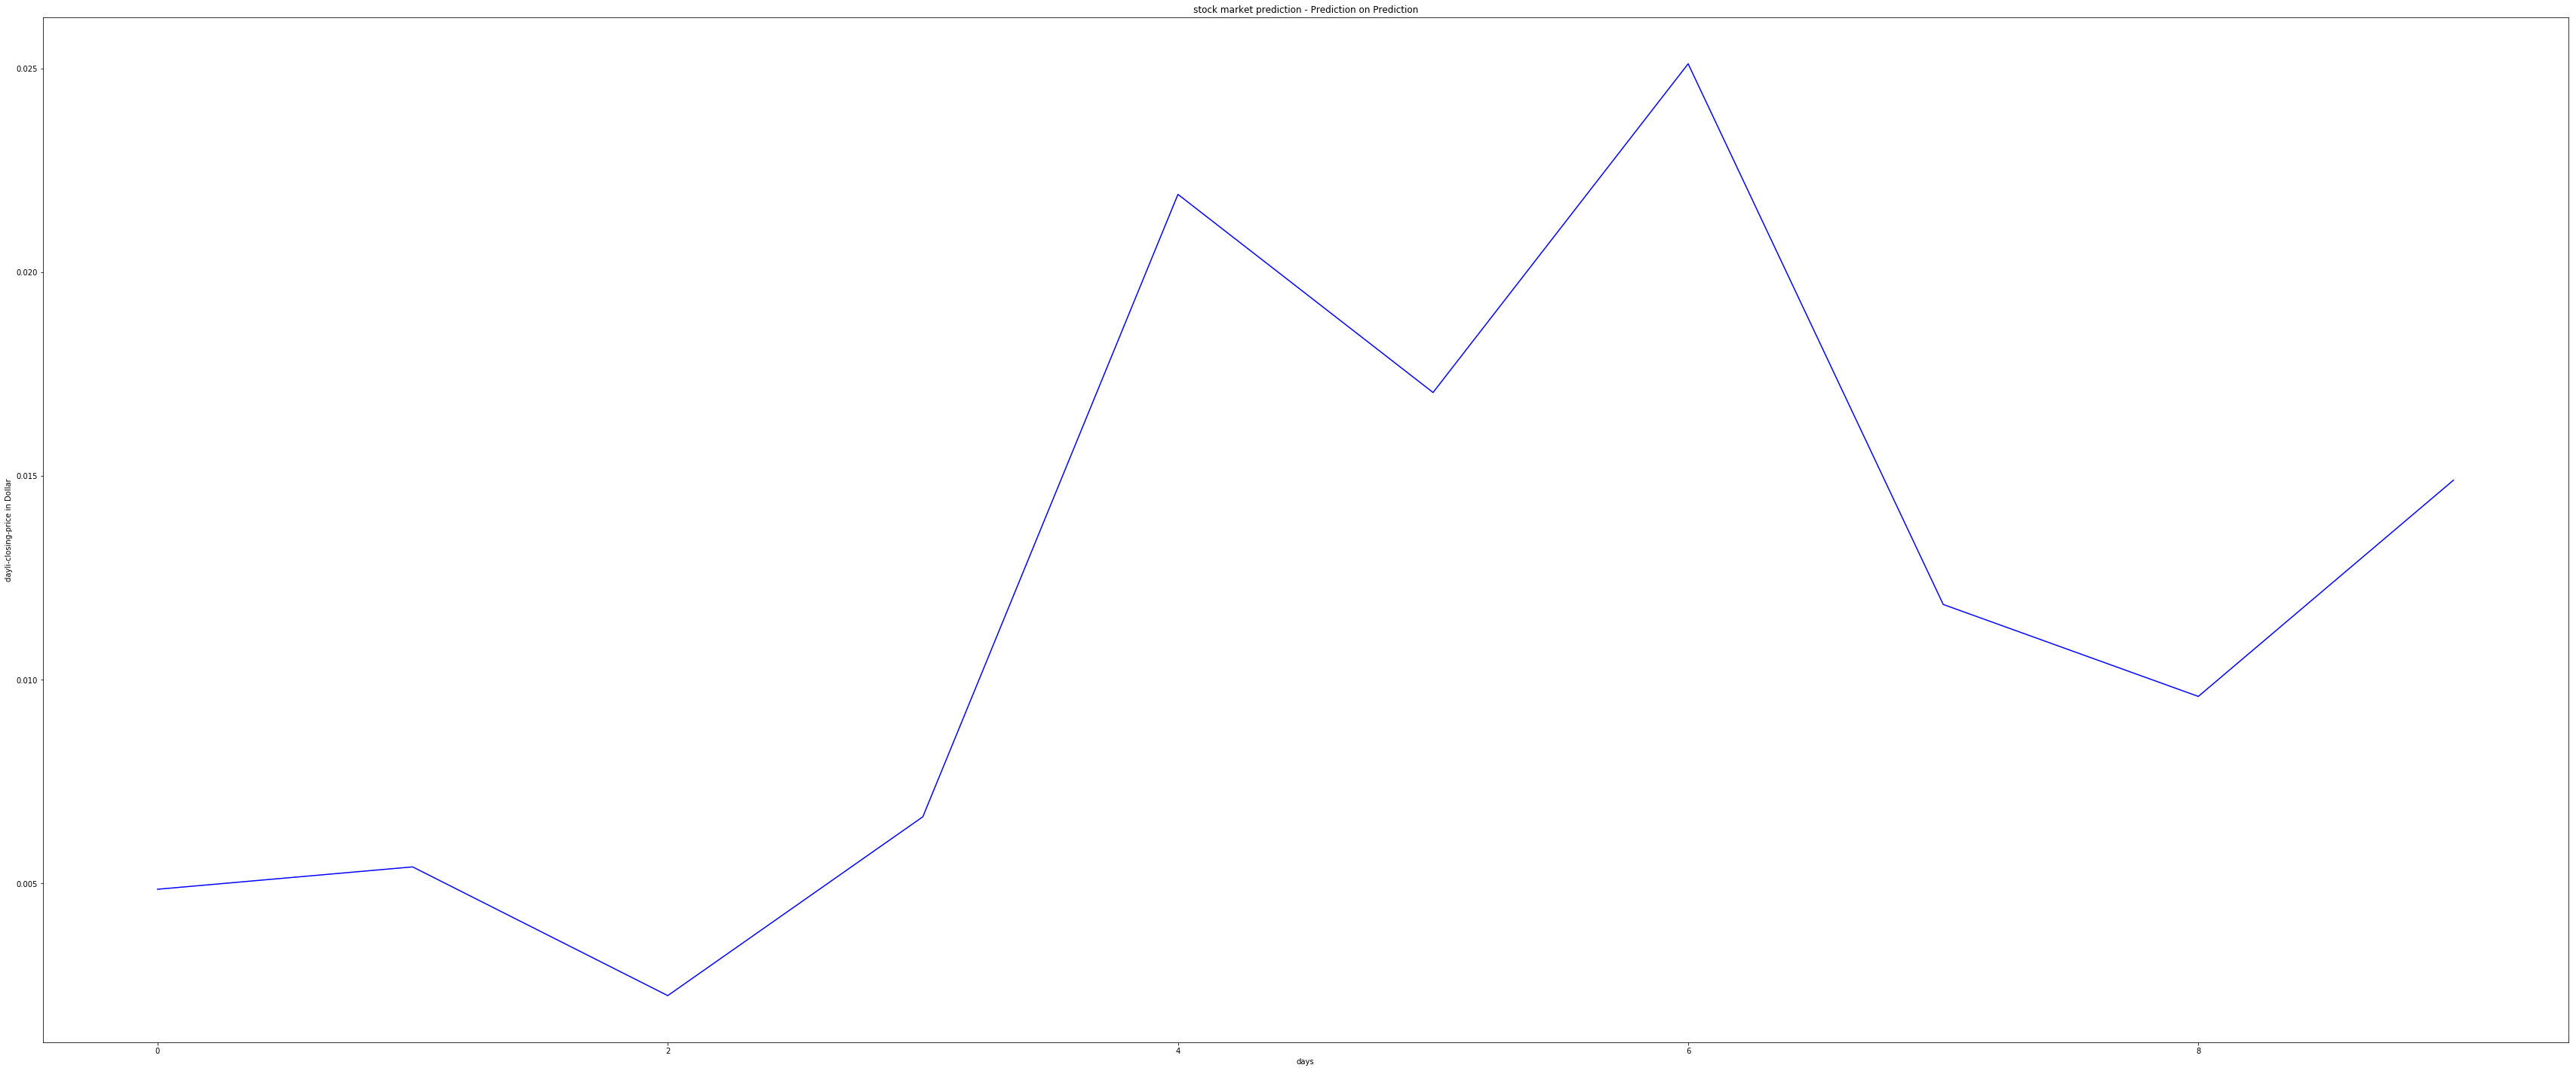


Number of existing points:  126
Number of predicted points:  80
Number of predicted points:  51




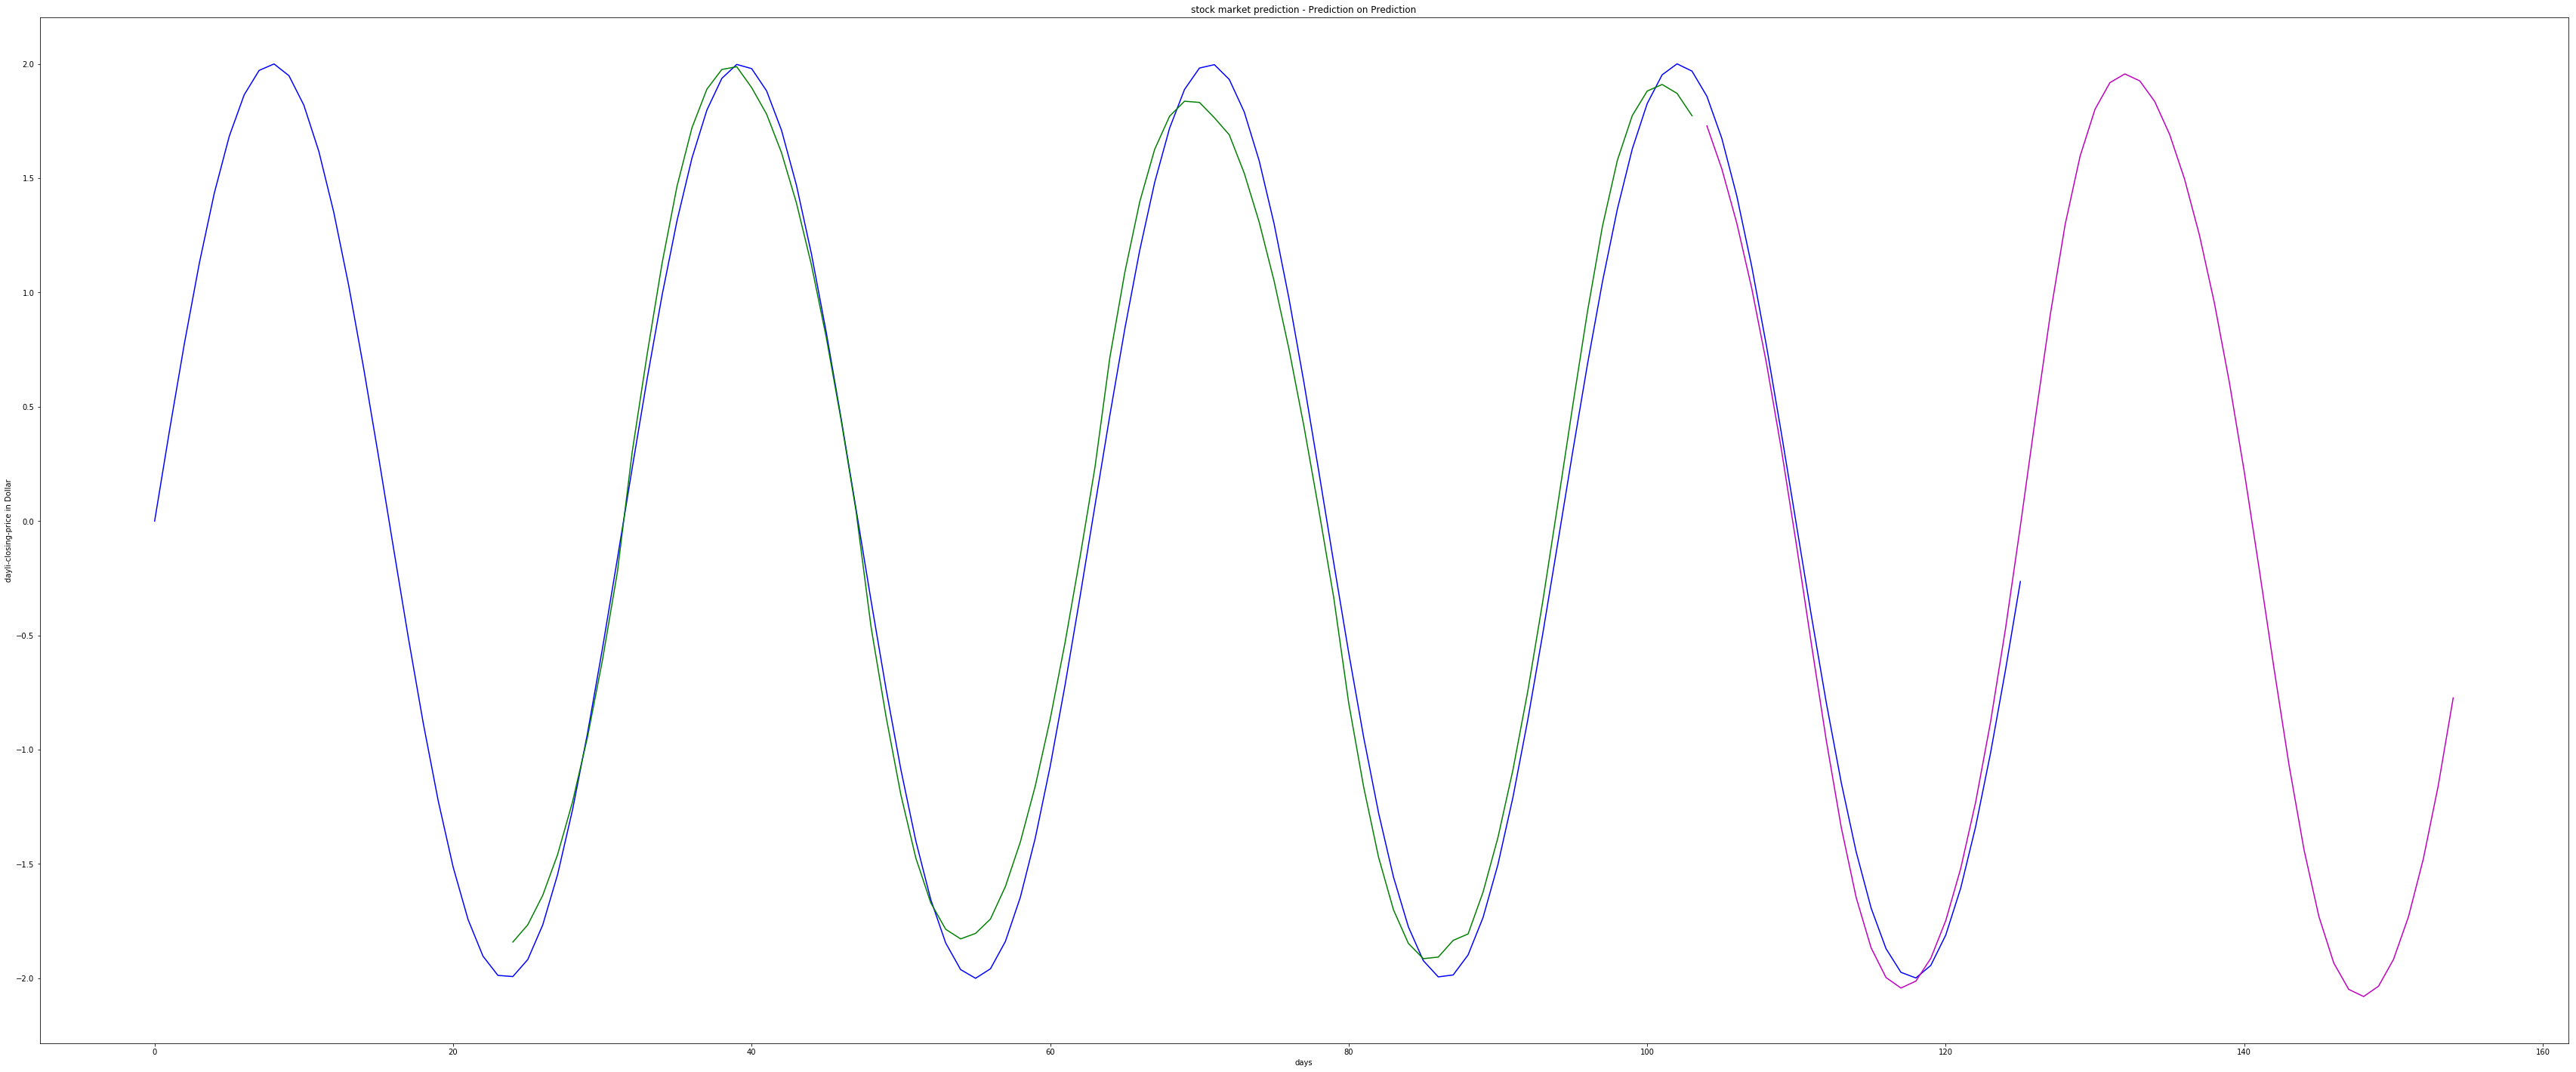

finished


In [30]:
###################################################
print("start")
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
run_all(sess)
sess.close()
print("finished")
###################################################